# <u>**Modélisation statistique de la valeur des joueurs de football à partir de leurs performances.**</u>

Par Roman Dupraz-Bardou, Lenny Ouakil et Paul Lemoine Vandermoere

## <u>**Introduction :**</u>

L’évaluation de la valeur des joueurs est une composante clé dans le football moderne. Des plateformes comme Transfermarkt et le CIES fournissent des estimations, mais les clubs cherchent souvent à obtenir des informations plus précises basées sur des performances actualisées. Ce projet vise à construire un modèle qui estime la valeur des joueurs à partir de diverses sources de données sur les performances (open data, scraping, API), puis à comparer les estimations avec celles des plateformes publiques comme Transfermarkt ou le CIES. Pour cela, nous nous concentrerons sur les sept grands championnats européens (Premier League, Ligue 1, Bundesliga, Liga, Serie A, Eredivisie, Liga Portugal) de 2015 à 2024 (championnats écourtés pour cause de pandémie du covid19).

Ainsi, nous nous attendons à observer une corrélation positive entre les performances des joueurs (nombre de buts, de passes décisives, taux de clean sheet...) et leur valeur. Afin d'obtenir un nombre conséquent de données nécessaires à la construction de ce modèle, nous utiliserons des API comme Footballdata.org qui offrent des statistiques détaillées sur les performances des joueurs des sept grands championnats européens (xG, passes clés, interceptions, dribbles, etc.), du scraping depuis des plateformes comme Transfermarkt pour récupérer les valeurs marchandes publiques des joueurs. Il pourrait aussi être intéressant d'intégrer des variables démographiques et/ou caractéristiques (âge, position, durée du contrat) depuis des sources telles que Transfermarkt ou d'autres bases de données disponibles en open data. 

### <u> Sommaire</u>

1. [Installation](#installation)
2. [Obtention des données](#obtention-des-données)
   - [Utilisation d'API](#utilisation-d'api)
   - [Scraping des données de valeur marchande](#scraping-des-données-de-valeur-marchande)
   - [Scraping des données de performances depuis FBref](#scraping-depuis-fbref)
   - [Cartographie](#cartographie)
3. [Statistiques descriptives](#statistiques-descriptives)
4. [Modèle de prédiction](#modèle-de-prédiction)
5. [Conclusion](#conclusion)


<a id="installation"></a>
## <u>**1. Installation** </u>

Afin de construire ce projet, nous avons eu besoin de différentes librairies : 


In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import folium
import webbrowser
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import time
import os
import random
import json
import io

<a id="obtention-des-données"></a>
## <u>2. Obtention des données</u>

<a id="utilisation-d'api"></a>
### <u> Utilisation d'API </u>

Dans un premier temps, il nous a paru intéressant d'utiliser des API afin de récupérer des données essentielles sur les joueurs. Il existe différentes API sur le sujet, mais pour des raisons d'efficacité, nous nous focaliserons sur celle fournie par Footballdata.org, dont le plan gratuit permet d'extraire davantage d'informations. Avec cette API, nous avons accès aux informations élémentaires sur les équipes de 10 championnats : Champions League, Primeira Liga, Premier League, Championship, Ligue 1, Eredivisie, Bundesliga, Serie A, Liga ainsi que la Serie A brésilienne. Nous sommes aussi en mesure de fournir des données de l'Euro 2024 et de la Coupe du Monde 2022.

Toutefois, nous nous concentrons ici sur les sept grands championnats européens, dont les ID sont 2021 (Premier League), 2014 (Liga), 2015 (Ligue 1), 2002 (Bundesliga), 2019 (Serie A), 2003 (Eredivisie), 2017 (Primeira Liga). Nous pouvons ainsi accéder à différentes informations sur les équipes qui composent ces championnats. Prenons le cas de la Premier League :

In [3]:
from infoapi import get_teams 

get_teams(2021) 


    Team ID                   Team Name      Short Name     Area  Founded  \
0        57                  Arsenal FC         Arsenal  England     1886   
1        58              Aston Villa FC     Aston Villa  England     1872   
2        61                  Chelsea FC         Chelsea  England     1905   
3        62                  Everton FC         Everton  England     1878   
4        63                   Fulham FC          Fulham  England     1879   
5        64                Liverpool FC       Liverpool  England     1892   
6        65          Manchester City FC        Man City  England     1880   
7        66        Manchester United FC      Man United  England     1878   
8        67         Newcastle United FC       Newcastle  England     1881   
9        73        Tottenham Hotspur FC       Tottenham  England     1882   
10       76  Wolverhampton Wanderers FC   Wolverhampton  England     1877   
11      338           Leicester City FC  Leicester City  England     1884   

Ainsi, grâce à ce data frame nous sommes en capacité d'observer les équipes présentes dans le championnat anglais, mais aussi leur ID. Cela nous permettra ensuite de pouvoir réaliser des recherches plus poussées sur ces équipes afin de nous concentrer sur les joueurs. Regardons plus en détail l'effectif de Manchester United, à l'aide d'un data frame ainsi que d'une représentation par poste: 

                Player Name            Position Date of Birth  \
0               André Onana          Goalkeeper    1996-04-02   
1                Tom Heaton          Goalkeeper    1986-04-15   
2            Altay Bayındır          Goalkeeper    1998-04-14   
3           Godwill Kukonki             Defence    2008-02-06   
4             Jack Fletcher            Midfield    2007-03-19   
5          Jayce Fitzgerald            Midfield    2007-05-09   
6             Manuel Ugarte  Defensive Midfield    2001-04-11   
7               Diogo Dalot          Right-Back    1999-03-18   
8               Jonny Evans         Centre-Back    1988-01-03   
9                 Luke Shaw           Left-Back    1995-07-12   
10              Mason Mount  Attacking Midfield    1999-01-10   
11        Noussair Mazraoui          Right-Back    1997-11-14   
12         Matthijs de Ligt         Centre-Back    1999-08-12   
13           Tyrell Malacia           Left-Back    1999-08-17   
14  Victor Nilsson-Lindel

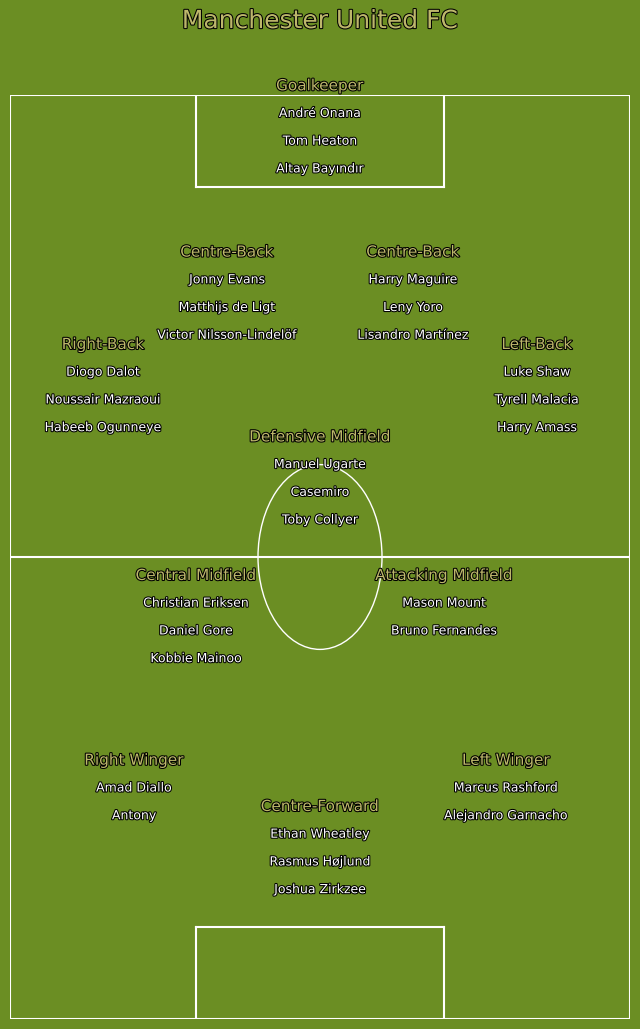

In [4]:
from infoapi import get_players 
from infoapi import draw_team

get_players(66) #crée le data frame de l'effectif
draw_team(66) #crée une représentation de l'effectif par poste 

Nous avons ainsi pu extraire des informations essentielles sur les joueurs de Manchester United. Toutefois, le plan gratuit ne nous permet pas d'accéder à la valeur marchande des joueurs, pourtant centrale dans notre projet. Il sera donc nécessaire d'utiliser d'autres moyens pour l'obtenir. C'est ce que nous allons voir désormais.

<a id="scraping-des-données-de-valeur-marchande"></a>
### <u>Scraping des données de valeur marchande </u>

''' Là Roman raconte sa partie'''

In [ ]:
'''Code de Roman sur la partie valeur marchande

Scraping plus court donc à voir si on fait tourner ou pas (question de reproductibilité)'''

<a id="scraping-depuis-fbref"></a>
### <u> Scraping des données de performances depuis FBref </u>

Dans le but de diversifier nos sources de données sur les joueurs, nous nous sommes aussi concentré sur le scraping des tableaux de données présents dans le site [FBref.com](https://fbref.com/en/). FBref est un site spécialisé dans les statistiques et les analyses détaillées de football et offre des données complètes sur les joueurs, les équipes et les compétitions du monde entier. Comme précisé précédemment, nous nous sommes accordés pour restreindre l'étude sur les 7 grands championnats européens (pour rappel : English Premier League , Spanish LaLiga, French Ligue 1, German Bundesliga, Italian Serie A, Dutch Eredivisie, Portuguese Primeira Liga). Le but est de récupérer tous les joueurs ayant joué dans un des 7 championnats au moins une saison durant les 10 dernières saisons (de 2015-2016 à 2024-2025) et de scraper leurs statistiques au moins depuis 2010-2011. Nous scraperons d'abord les joueurs d'Eredivisie puis de Primeira Liga et enfin le top5 en une seule fois.




Expliquons d'abord le procédé pour le scraping des joueurs d'Eredivisie. 
Nous commençons par coder une fonction qui nous donne tous les urls des clubs présents dans la ligue à une saison donnée. Pour cela, il faut accéder à la table qui contient tous les clubs de la ligue à une saison donnée dont l'id est "results{season}231_overall" et récupérer l'url de chaque club présent dans la table : 

In [3]:
def get_club_urls(league_url, season):
    """Get URLs for all clubs in the league for a specific season"""
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(league_url, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Replace dynamic ID based on the season
    table_id = f"results{season}231_overall"
    clubs_table = soup.find("table", id=table_id)
    
    if not clubs_table:
        raise ValueError(f"Could not find the clubs table with ID: {table_id}")

    club_links = []
    for row in clubs_table.find_all("tr"):
        first_col = row.find("td", {"data-stat": "team"})
        if first_col and first_col.find("a"):
            link0 = "https://fbref.com" + first_col.find("a")["href"]
            club_links.append(link0)
    
    return club_links

Le dictionnaire HEADERS est utilisé pour définir des en-têtes HTTP personnalisés lors de la requête effectuée avec requests.get. Ces en-têtes sont principalement utiles pour éviter d'être bloqué par le serveur.

In [4]:
get_club_urls("https://fbref.com/en/comps/23/2023-2024/2023-2024-Eredivisie-Stats", "2023-2024")

['https://fbref.com/en/squads/e334d850/2023-2024/PSV-Eindhoven-Stats',
 'https://fbref.com/en/squads/fb4ca611/2023-2024/Feyenoord-Stats',
 'https://fbref.com/en/squads/a1f721d3/2023-2024/Twente-Stats',
 'https://fbref.com/en/squads/3986b791/2023-2024/AZ-Alkmaar-Stats',
 'https://fbref.com/en/squads/19c3f8c4/2023-2024/Ajax-Stats',
 'https://fbref.com/en/squads/fc629994/2023-2024/NEC-Nijmegen-Stats',
 'https://fbref.com/en/squads/2a428619/2023-2024/Utrecht-Stats',
 'https://fbref.com/en/squads/146a68ce/2023-2024/Sparta-Rotterdam-Stats',
 'https://fbref.com/en/squads/e33d6108/2023-2024/Go-Ahead-Eagles-Stats',
 'https://fbref.com/en/squads/bd08295c/2023-2024/Fortuna-Sittard-Stats',
 'https://fbref.com/en/squads/193ff7aa/2023-2024/Heerenveen-Stats',
 'https://fbref.com/en/squads/e3db180b/2023-2024/Zwolle-Stats',
 'https://fbref.com/en/squads/2b41acb5/2023-2024/Almere-City-Stats',
 'https://fbref.com/en/squads/c882b88e/2023-2024/Heracles-Almelo-Stats',
 'https://fbref.com/en/squads/bb14adb3/

Ensuite il faut une fonction qui renvoie pour chaque club la liste d'url de chaque joueurs. On récupère la table de joueurs d'id "stats_standard_23" et on construit les liens pour avoir la page des joueurs sur toutes les compétitions confondues: 

In [7]:
def scrape_club_players(club_url):
    """Get player links for a specific club"""
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    time.sleep(random.uniform(3, 4))  # random delay
    
    response = requests.get(club_url, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    players_table = soup.find("table", id="stats_standard_23")
    
    if not players_table:
        print(f"Warning: no players table for {club_url} ")
        return []

    player_links = []
    for row in players_table.find_all("tr"):
        player_cell = row.find("th", {"data-stat": "player"})
        if player_cell and player_cell.find("a"):
            player_link = player_cell.find("a")["href"]
            
            # Build complete URL
            linkbefore = "https://fbref.com" + player_link
            linkmid = linkbefore.split("/")
            linkmid.insert(6, "all_comps")
            full_url = "/".join(linkmid) + "-Stats---All-Competitions"
            
            player_links.append(full_url)
    
    return player_links


On utilise une pause random entre 3 et 4 secondes de pause de manière random pour que le serveur ait plus de mal à détecter le fait que le scraping est automatisé. 

In [8]:
scrape_club_players("https://fbref.com/en/squads/e334d850/2023-2024/PSV-Eindhoven-Stats")

['https://fbref.com/en/players/abb3bb95/all_comps/Luuk-de-Jong-Stats---All-Competitions',
 'https://fbref.com/en/players/8a2248b4/all_comps/Walter-Benitez-Stats---All-Competitions',
 'https://fbref.com/en/players/403f5d20/all_comps/Olivier-Boscagli-Stats---All-Competitions',
 'https://fbref.com/en/players/0caa2fd4/all_comps/Johan-Bakayoko-Stats---All-Competitions',
 'https://fbref.com/en/players/82e9b1bb/all_comps/Jordan-Teze-Stats---All-Competitions',
 'https://fbref.com/en/players/7483d9f9/all_comps/Andre-Ramalho-Stats---All-Competitions',
 'https://fbref.com/en/players/2cfae697/all_comps/Jerdy-Schouten-Stats---All-Competitions',
 'https://fbref.com/en/players/18fae4ac/all_comps/Joey-Veerman-Stats---All-Competitions',
 'https://fbref.com/en/players/5976f83e/all_comps/Sergino-Dest-Stats---All-Competitions',
 'https://fbref.com/en/players/6e44569a/all_comps/Guus-Til-Stats---All-Competitions',
 'https://fbref.com/en/players/a5420709/all_comps/Malik-Tillman-Stats---All-Competitions',
 'h

Et maintenant il nous faut une fonction qui, pour chaque joueur, récupère la table de données pour toutes les saisons plus récentes que 2010-2011. La table s'appelle soit "stats_standard_expanded" soit "stats_standard_dom_lg" selon les joueurs. Cependant la table du site  est une table dont les colonnes sont multiindexées : 

In [27]:
#Exemple avec la table de Luuk de 
# Jong
HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
response = requests.get("https://fbref.com/en/players/abb3bb95/Luuk-de-Jong", headers=HEADERS)
soup = BeautifulSoup(response.text, 'html.parser')
stats_table = soup.find("table", id="stats_standard_dom_lg")
stats_table_html = str(stats_table)
stats_table = pd.read_html(io.StringIO(stats_table_html), header=[0, 1])[0]


print(stats_table.columns)
    

MultiIndex([( 'Unnamed: 0_level_0',   'Season'),
            ( 'Unnamed: 1_level_0',      'Age'),
            ( 'Unnamed: 2_level_0',    'Squad'),
            ( 'Unnamed: 3_level_0',  'Country'),
            ( 'Unnamed: 4_level_0',     'Comp'),
            ( 'Unnamed: 5_level_0',   'LgRank'),
            ( 'Unnamed: 6_level_0',       'MP'),
            (       'Playing Time',   'Starts'),
            (       'Playing Time',      'Min'),
            (       'Playing Time',      '90s'),
            (        'Performance',      'Gls'),
            (        'Performance',      'Ast'),
            (        'Performance',      'G+A'),
            (        'Performance',     'G-PK'),
            (        'Performance',       'PK'),
            (        'Performance',    'PKatt'),
            (        'Performance',     'CrdY'),
            (        'Performance',     'CrdR'),
            (           'Expected',       'xG'),
            (           'Expected',     'npxG'),
            (       

Il faut alors créer une fonction qui aplatit les colonnes tout en les renommant de manière à ce que le nom de la colonne de l'index le plus haut soit suivi de ':' et du nom de la colonne du deuxième index (lorsque le premier index commence par 'Unnamed' , on choisi de garder seulement le nom du deuxième index). Pour donner un exemple : la colonne ('Performance','Gls') devient 'Performance : Gls' et 
('Unnamed: 0_level_0', 'Season') devient 'Season'.

In [28]:
def rename_columns_and_flatten(df):
    new_columns = []
    for col in df.columns:
        # Si le niveau supérieur commence par "Unnamed", on garde uniquement le niveau inférieur
        if str(col[0]).startswith("Unnamed"):
            new_columns.append(col[1])
        else:
            # Sinon, on combine le niveau supérieur et le niveau inférieur avec ":"
            new_columns.append(f"{col[0]} : {col[1]}")
    
    # Appliquer les nouveaux noms de colonnes
    df.columns = new_columns
    # Aplatir les colonnes si elles sont multi-indexées
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]
    
    return df

In [29]:
print(rename_columns_and_flatten(stats_table).columns)


Index(['Season', 'Age', 'Squad', 'Country', 'Comp', 'LgRank', 'MP',
       'Playing Time : Starts', 'Playing Time : Min', 'Playing Time : 90s',
       'Performance : Gls', 'Performance : Ast', 'Performance : G+A',
       'Performance : G-PK', 'Performance : PK', 'Performance : PKatt',
       'Performance : CrdY', 'Performance : CrdR', 'Expected : xG',
       'Expected : npxG', 'Expected : xAG', 'Expected : npxG+xAG',
       'Progression : PrgC', 'Progression : PrgP', 'Progression : PrgR',
       'Per 90 Minutes : Gls', 'Per 90 Minutes : Ast', 'Per 90 Minutes : G+A',
       'Per 90 Minutes : G-PK', 'Per 90 Minutes : G+A-PK',
       'Per 90 Minutes : xG', 'Per 90 Minutes : xAG',
       'Per 90 Minutes : xG+xAG', 'Per 90 Minutes : npxG',
       'Per 90 Minutes : npxG+xAG', 'Matches'],
      dtype='object')


On peut maintenant coder une fonction qui récupère la table du joueur en rajoutant une colonne 'Player' qui donne le nom du joueur et en appliquant la fonction précédente pour reshape le dataframe obtenu. De plus, pour optimiser notre scraping en temps et en espace, nous avons rajouté un argument à la fonction 'existing_players' pour ne pas scraper la table d'un joueur si le joueur est déja dans existing_players 

In [32]:
def scrape_stats_player(player_url, existing_players):
    """Get statistics for a specific player if not already in the dataset."""
    player_name = player_url.split("/")[-1].replace("-Stats---All-Competitions", "").replace("-", " ")

    if player_name in existing_players:
        print(f"Skipping {player_name} (already exists in the dataset).")
        return pd.DataFrame()

    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    time.sleep(random.uniform(3, 4)) # random delay

    try:
        response = requests.get(player_url, headers=HEADERS)
        soup = BeautifulSoup(response.text, 'html.parser')
        stats_table = soup.find("table", id="stats_standard_expanded")
        
        if stats_table is None:
            stats_table = soup.find("table", id="stats_standard_dom_lg")
            
        if stats_table is None:
            print(f"No stats table found for URL: {player_url}")
            return pd.DataFrame()

        # Convertir le tableau HTML en DataFrame
        try:
            stats_table_html = str(stats_table)  # Convertir en chaîne
            stats_table = pd.read_html(io.StringIO(stats_table_html), header=[0, 1])[0]
        except ValueError as e:
            print(f"Error reading HTML table for {player_name}: {e}")
            return pd.DataFrame()

        # Créer une copie explicite pour éviter le SettingWithCopyWarning
        stats_table = stats_table.copy()

        # Ajouter le nom du joueur
        stats_table.loc[:, ('Unnamed: -1_level_0', 'Player')] = player_name

        # Reorder columns for consistency
        new_order = [('Unnamed: -1_level_0', 'Player')] + list(stats_table.columns[:-1])
        stats_table = stats_table[new_order]

        # Renommer les colonnes et les aplatir
        stats_table = rename_columns_and_flatten(stats_table)

        # Définir la liste des saisons autorisées
        allowed_seasons = ['2010-2011', '2011-2012', '2012-2013', '2013-2014','2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', 
            '2022-2023', '2023-2024', '2024-2025']

        season_column = 'Season'
        if season_column in stats_table.columns:
            stats_table = stats_table[stats_table[season_column].isin(allowed_seasons)]

        return stats_table
    except Exception as e:
        print(f"Error scraping stats for {player_name}: {e}")
        return pd.DataFrame()

In [42]:
scrape_stats_player("https://fbref.com/en/players/abb3bb95/Luuk-de-Jong", []).head()

,Player,Season,Age,Squad,Country,Comp,LgRank,MP,Playing Time : Starts,Playing Time : Min,...,Per 90 Minutes : Ast,Per 90 Minutes : G+A,Per 90 Minutes : G-PK,Per 90 Minutes : G+A-PK,Per 90 Minutes : xG,Per 90 Minutes : xAG,Per 90 Minutes : xG+xAG,Per 90 Minutes : npxG,Per 90 Minutes : npxG+xAG,Matches
2,Luuk de Jong,2010-2011,19,Twente,nl NED,1. Eredivisie,2nd,32,31,2763,...,0.26,0.65,0.39,0.65,NaN,NaN,NaN,NaN,NaN,Matches
3,Luuk de Jong,2011-2012,20,Twente,nl NED,1. Eredivisie,6th,31,31,2761,...,0.26,1.08,0.78,1.04,NaN,NaN,NaN,NaN,NaN,Matches
4,Luuk de Jong,2012-2013,21,Gladbach,de GER,1. Bundesliga,8th,23,17,1407,...,0.13,0.51,0.38,0.51,NaN,NaN,NaN,NaN,NaN,Matches
5,Luuk de Jong,2013-2014,22,Gladbach,de GER,1. Bundesliga,6th,13,0,85,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,Matches
6,Luuk de Jong,2013-2014,22,Newcastle Utd,eng ENG,1. Premier League,10th,12,8,667,...,0.13,0.13,0.00,0.13,NaN,NaN,NaN,NaN,NaN,Matches


In [43]:
scrape_stats_player("https://fbref.com/en/players/abb3bb95/Luuk-de-Jong", ['Luuk de Jong'])

Skipping Luuk de Jong (already exists in the dataset).


""


<a id="cartographie"></a>
### <u>Cartographie </u>

Dans le cadre de notre projet, nous avons aussi souhaité réutiliser des méthodes que nous avions découvertes lors du cours de *Python pour la data science*. C'est pourquoi nous avons voulu créer une nouvelle carte des stades de Ligue 1 et Ligue 2, actualisée à la saison 2024/2025, en distinguant les stades appartenant à des clubs de Ligue 1 et de Ligue 2.

In [3]:
from mapping import retrieve_all_stadium_from_league

# URLs for different divisions
url_list = {
    "L1": "http://fr.wikipedia.org/wiki/Championnat_de_France_de_football_2024-2025",
    "L2": "https://fr.wikipedia.org/wiki/Championnat_de_France_de_football_de_deuxi%C3%A8me_division_2024-2025",
}

# Retrieve stadiums information for Ligue 1
stades_ligue1 = retrieve_all_stadium_from_league(url_list, "L1")
stades_ligue2 = retrieve_all_stadium_from_league(url_list, "L2")

stades = pd.concat([stades_ligue1, stades_ligue2])

stades = stades.dropna(subset=["latitude", "longitude"])
stades.loc[:, ["latitude", "longitude"]] = stades.loc[
    :, ["latitude", "longitude"]
].astype(float)
stadium_locations = gpd.GeoDataFrame(
    stades, geometry=gpd.points_from_xy(stades.longitude, stades.latitude)
)

center = stadium_locations[["latitude", "longitude"]].mean().values.tolist()
sw = stadium_locations[["latitude", "longitude"]].min().values.tolist()
ne = stadium_locations[["latitude", "longitude"]].max().values.tolist()

m = folium.Map(location=center, tiles="openstreetmap")

# I can add marker one by one on the map
for i in range(0, len(stadium_locations)):
    row = stadium_locations.iloc[i]
    color = "blue" if row["division"] == "L1" else "green"
    folium.Marker(
        [stadium_locations.iloc[i]["latitude"], stadium_locations.iloc[i]["longitude"]],
        popup=stadium_locations.iloc[i]["stade"],  icon=folium.Icon(color=color)
    ).add_to(m)

m.fit_bounds([sw, ne])
m.save("stadiums_map.html")
webbrowser.open("stadiums_map.html")

Retrieving information for Angers Sporting Club de l'Ouest
Retrieving information for Association de la jeunesse auxerroise
Retrieving information for Stade brestois 29
Retrieving information for Le Havre Athletic Club (football)
Retrieving information for Racing Club de Lens
Retrieving information for LOSC Lille
Retrieving information for Olympique lyonnais
Retrieving information for Olympique de Marseille
Retrieving information for Association sportive de Monaco Football Club
Retrieving information for Montpellier Hérault Sport Club
Retrieving information for Football Club de Nantes
Retrieving information for Olympique Gymnaste Club de Nice
Retrieving information for Paris Saint-Germain Football Club
Retrieving information for Stade de Reims
Retrieving information for Stade rennais Football Club
Retrieving information for Association sportive de Saint-Étienne
Retrieving information for Racing Club de Strasbourg Alsace
Retrieving information for Toulouse Football Club
Retrieving infor

True

<a id="statistiques-descriptives"></a>
## <u>3. Statistiques descriptives</u>

Il s'agit désormais d'utiliser les données que nous avons récupérées afin de mieux comprendre certains enjeux liés aux transferts de joueurs. 